In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# cd /content/drive/MyDrive/sentence_level

In [ ]:
! pip install transformers

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import time
import argparse
import logging
import sys

In [ ]:
def read_data(txt_file, ann_file):
    with open(txt_file, 'r', encoding='utf-8') as txt_reader:
        txt = txt_reader.read().replace(u'\xa0', u' ')
        sents = txt.split('\n')

    if os.path.exists(ann_file):
        with open(ann_file, 'r', encoding='utf-8') as ann_reader:
            anns = ann_reader.read().split('\n')
    else:
        anns = []

    data = []

    ann_dict = {}
    for ann in anns:
        items = ann.split('\t')
        if len(items) < 2:
            continue
        key = items[0]
        ann_dict[key] = items[1:]

    start_sent = -1
    end_sent = -1
    for sent in sents:
        start_sent = end_sent + 1
        end_sent = start_sent + len(sent)

        tmp = {
            'text': sent,
            'annotation': []
        }

        has_event = False
        for key in ann_dict:
            if len(key) > 0 and key[0] == 'E':
                args = ann_dict[key][0].split()
                event, event_key = args[0].split(':')[0:2]
                start_trigger, end_trigger = ann_dict[event_key][0].split()[1:3]
                start_trigger = int(start_trigger)
                end_trigger = int(end_trigger)
                if start_trigger >= start_sent and end_trigger <= end_sent:
                    tmp_ann = {
                        'event': event,
                        'trigger': ann_dict[event_key][1],
                        'start_trigger': start_trigger,
                        'end_trigger': end_trigger,
                        'argument': []
                    }

                    for i in range(1, len(args)):
                        type, type_key = args[i].split(':')[0:2]
                        arg_text = ann_dict[type_key][1]
                        entity, start_arg, end_arg = ann_dict[type_key][0].split()[0:3]

                        tmp_arg = {
                            'text': arg_text,
                            'type': type.split('-')[0],
                            'entity': entity,
                            'start_arg': int(start_arg),
                            'end_arg': int(end_arg)
                        }
                        tmp_ann['argument'].append(tmp_arg)

                    tmp['annotation'].append(tmp_ann)
                    has_event = True

        if not has_event:
            tmp_ann = {
                'event': 'Other'
            }
            tmp['annotation'].append(tmp_ann)

        data.append(tmp)

    l = 0
    for i in range(len(data)):
        if len(data[i]['annotation']) > 0 and 'start_trigger' in data[i]['annotation'][0]:
            for j in range(len(data[i]['annotation'])):
                data[i]['annotation'][j]['start_trigger'] -= l
                data[i]['annotation'][j]['end_trigger'] -= l
                for k in range(len(data[i]['annotation'][j]['argument'])):
                    data[i]['annotation'][j]['argument'][k]['start_arg'] -= l
                    data[i]['annotation'][j]['argument'][k]['end_arg'] -= l
        l += len(data[i]['text']) + 1

    return data

In [ ]:
label_classes = [
    "Acquit", "Appeal", "Arrest-jail", "Attack", "Be-born", "Charge-indict", "Convict",
    "Declare-bankruptcy", "Demonstrate", "Die", "Divorce", "Elect", "End-org", "End-position",
    "Execute", "Extradite", "Fine", "Injure", "Marry", "Meet", "Merge-org", "Nominate", "Other",
    "Pardon", "Phone-write", "Release-parole", "Sentence", "Start-org", "Start-position",
    "Sue", "Transfer-money", "Transfer-ownership", "Transport", "Trial-hearing"
]

In [ ]:
def convert_to_binary_labels(data, label_classes):
    binary_data = []

    for item in data:
        labels = [0] * len(label_classes)
        for annotation in item['annotation']:
            if annotation['event'] in label_classes:
                labels[label_classes.index(annotation['event'])] = 1
        binary_data.append({
            'text': item['text'],
            'labels': labels
        })

    return binary_data

In [ ]:
def read_data_directory(data_dir):
    train_data = []
    dev_data = []
    test_data = []

    for sub_dir in ['train', 'dev', 'test']:
        dir_path = os.path.join(data_dir, sub_dir)
        for file_name in os.listdir(dir_path):
            if file_name.endswith('.txt'):
                txt_file = os.path.join(dir_path, file_name)
                ann_file = os.path.join(dir_path, file_name.replace('.txt', '.ann'))

                data = read_data(txt_file, ann_file)
                binary_data = convert_to_binary_labels(data, label_classes)
                if sub_dir == 'train':
                    train_data.extend(binary_data)
                elif sub_dir == 'dev':
                    dev_data.extend(binary_data)
                elif sub_dir == 'test':
                    test_data.extend(binary_data)

    return train_data, dev_data, test_data

In [ ]:
class MultiLabelDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.data = data
        self.texts = [item['text'] for item in data]
        self.labels = [item['labels'] for item in data]
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.texts[index])
        labels = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(labels)
        }


In [ ]:
class BertForMLC(nn.Module):
    def __init__(self, n_classes):
        super(BertForMLC, self).__init__()
        self.bert = BertModel.from_pretrained('FPTAI/vibert-base-cased')
        self.dropout = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[1]
        output = self.dropout(pooled_output)
        return self.out(output)


In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    losses = []

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = loss_fn(outputs, labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    return np.mean(losses)


In [ ]:
def setup_logging(log_file):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

    if logger.hasHandlers():
        logger.handlers.clear()

    file_handler = logging.FileHandler(log_file)
    logger.addHandler(file_handler)

    stream_handler = logging.StreamHandler(sys.stdout)
    logger.addHandler(stream_handler)

    return logger

In [ ]:
def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    y_pred, y_true = [], []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            loss = loss_fn(outputs, labels)
            losses.append(loss.item())

            # Apply sigmoid activation function
            outputs = torch.sigmoid(outputs).cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()

            y_pred.append(outputs)
            y_true.append(labels)

    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    y_pred = (y_pred > 0.5).astype(int)

    precision = precision_score(y_true, y_pred, average='micro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='micro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)

    return np.mean(losses), precision, recall, f1, y_true, y_pred

In [ ]:
def train_and_evaluate(args):
    # Setup directories
    output_dir = args.output_dir
    os.makedirs(output_dir, exist_ok=True)
    log_file = os.path.join(output_dir, 'bert_training.log')
    weight_file = os.path.join(output_dir, 'best_bert_model.pth')
    logger = setup_logging(log_file)

    # Read data
    train_data, dev_data, test_data = read_data_directory(args.data_dir)

    # Create tokenizer
    tokenizer = AutoTokenizer.from_pretrained(args.model)

    # Create dataset and dataloader
    train_dataset = MultiLabelDataset(train_data, tokenizer, args.max_length)
    dev_dataset = MultiLabelDataset(dev_data, tokenizer, args.max_length)
    test_dataset = MultiLabelDataset(test_data, tokenizer, args.max_length)

    train_data_loader = DataLoader(train_dataset, batch_size=args.train_batch_size, shuffle=True)
    dev_data_loader = DataLoader(dev_dataset, batch_size=args.eval_batch_size, shuffle=False)
    test_data_loader = DataLoader(test_dataset, batch_size=args.eval_batch_size, shuffle=False)

    # Setup model
    model = BertForMLC(n_classes=len(label_classes))
    model = model.to(device)

    # Setup optimizer, scheduler, and loss function
    optimizer = AdamW(model.parameters(), lr=args.lr, correct_bias=False)
    total_steps = len(train_data_loader) * args.num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(args.warmup_proportion * total_steps),
        num_training_steps=total_steps
    )
    loss_fn = nn.BCEWithLogitsLoss().to(device)

    # Train and evaluate model
    best_f1 = 0
    for epoch in range(args.num_epochs):
        logger.info(f'Epoch {epoch + 1}/{args.num_epochs}')
        logger.info('-' * 10)

        start_time = time.time()
        train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler)
        end_time = time.time()

        epoch_time = end_time - start_time
        logger.info(f'Epoch {epoch + 1} training time: {epoch_time:.2f} seconds')
        logger.info(f'Train loss {train_loss}')

        dev_loss, dev_precision, dev_recall, dev_f1 = eval_model(model, dev_data_loader, loss_fn, device)[:4]
        logger.info(f'Dev loss {dev_loss} Precision {dev_precision} Recall {dev_recall} F1 {dev_f1}')

        # Save best model weights
        if dev_f1 > best_f1:
            best_f1 = dev_f1
            torch.save(model.state_dict(), weight_file)
            logger.info(f'Saved best model weights to {weight_file}')

    # Evaluate model
    model.load_state_dict(torch.load(weight_file))
    test_loss, test_precision, test_recall, test_f1, y_true, y_pred = eval_model(model, test_data_loader, loss_fn, device)
    logger.info(f'Test loss {test_loss} Precision {test_precision} Recall {test_recall} F1 {test_f1}')

    # Confusion Matrix
    y_true_labels = y_true.argmax(axis=1)
    y_pred_labels = y_pred.argmax(axis=1)
    conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

    plt.figure(figsize=(18, 18))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_classes, yticklabels=label_classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
args = argparse.Namespace(
    model='FPTAI/vibert-base-cased',
    data_dir='/kaggle/input/dataset-bkee/data',
    output_dir='output',
    train_batch_size=8,
    eval_batch_size=8,
    lr=2e-5,
    num_epochs=5,
    log_step=100,
    warmup_proportion=0.1,
    no_cuda=False,
    gradient_accumulation_steps=1,
    max_length=256
)


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/581M [00:00<?, ?B/s]

Epoch 1/5
----------


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 training time: 352.63 seconds
Train loss 0.1341236103767729
Dev loss 0.06730296939490288 Precision 0.7757836198179979 Recall 0.5907603464870067 F1 0.6707463665173206
Saved best model weights to output/best_bert_model.pth
Epoch 2/5
----------
Epoch 2 training time: 353.44 seconds
Train loss 0.06536116017907566
Dev loss 0.05871545040177378 Precision 0.8452348628835189 Recall 0.5992300288739172 F1 0.701284072989412
Saved best model weights to output/best_bert_model.pth
Epoch 3/5
----------
Epoch 3 training time: 353.07 seconds
Train loss 0.05488278609040791
Dev loss 0.05386324855991132 Precision 0.8529180842711332 Recall 0.6273339749759385 F1 0.7229370008873114
Saved best model weights to output/best_bert_model.pth
Epoch 4/5
----------
Epoch 4 training time: 352.70 seconds
Train loss 0.04468489209922592
Dev loss 0.050192077466612306 Precision 0.8748321246306742 Recall 0.626948989412897 F1 0.7304328324736488
Saved best model weights to output/best_bert_model.pth
Epoch 5/5
---------

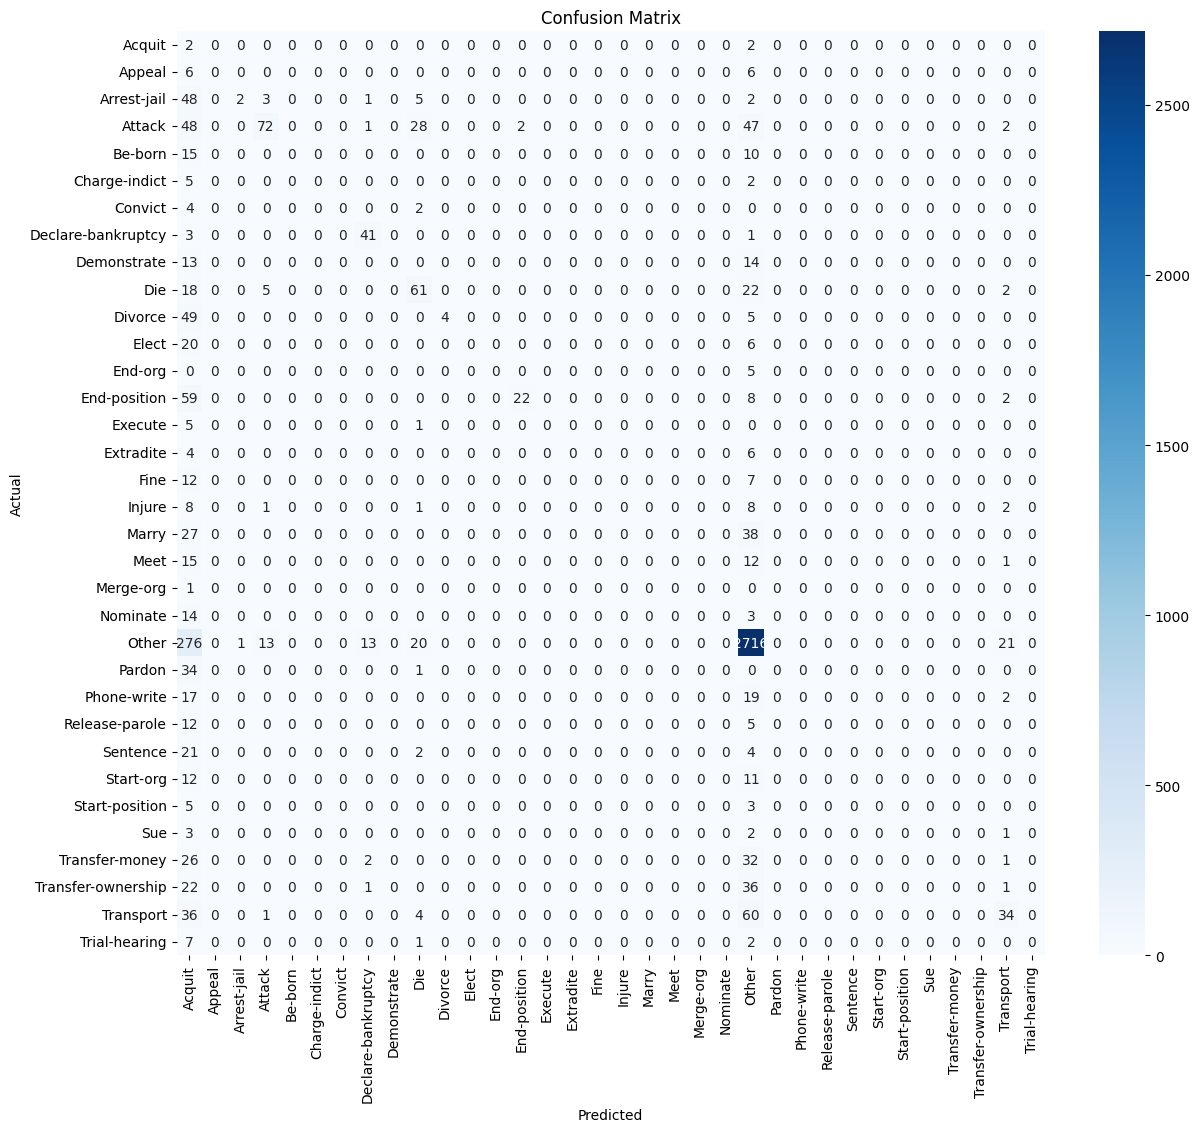

In [ ]:
if args.no_cuda:
    device = torch.device("cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_and_evaluate(args)